In [2]:
#Import packages and MNIST data
!pip install tensorly
import scipy.misc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST
from torch.autograd import Variable
from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.decomposition import FactorAnalysis, PCA

import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac

import tensorflow as tf
from torchvision import transforms

     |████████████████████████████████| 112kB 9.1MB/s 
     |████████████████████████████████| 163kB 14.0MB/s 
  Created wheel for tensorly: filename=tensorly-0.5.1-cp37-none-any.whl size=149171 sha256=cc21dfa2a844fa2642e2adef57f9438948868527b8dd36f2e5aac58507f8ea6c
  Stored in directory: /root/.cache/pip/wheels/88/1e/e7/b9677b2046cc87e17931b4b5781941786d3ee647825ca40ea6
Successfully built tensorly


In [3]:
# making 4D decomposition depend on RANK
dim = 28

mnist_trainset = MNIST("/work/Speciale/PreProject/02456/Week3/temp", train=True, download=True)
mnist_testset = MNIST("/work/Speciale/PreProject/02456/Week3/temp", train=False, download=True)

# Retrieving the numbers
nine1 = mnist_trainset.data[43].view(-1, 784).float()
nine2 = mnist_trainset.data[45].view(-1, 784).float()
inputchannel = 2
outputchannel = 2
spatialx = 3
spatialy = 3

nine = torch.cat((torch.tensor(nine1).reshape(1,1,dim,dim), torch.tensor(nine2).reshape(1,1,dim,dim)), 1)

# Creating the filter, the decomposition, and the application of the filters to the pictures.
randomFilter1 = torch.tensor([[[1,0,0],[1,0,0],[1,0,0]],[[1,0,1],[0,1,0],[1,0,1]]]).reshape(2,3,3,1)
#randomFilter2 = torch.tensor(np.random.rand(2,3,3)).reshape(2,3,3,1)
randomFilter2 = torch.tensor([[[.6,.5,.5],[.8,1,.3],[.2,.1,.3]],[[.2,.2,.1],[.4,.4,.3],[.6,.6,.5]]]).reshape(2,3,3,1)
randomFilter = torch.cat((randomFilter1,randomFilter2),3)
convrandomFilter1 = F.conv2d(nine, randomFilter1.reshape(1,2,3,3).float(), padding = 1)
convrandomFilter2 = F.conv2d(nine, randomFilter2.reshape(1,2,3,3).float(), padding = 1)

RANKLIST = [10,9,8]

fig, axs = plt.subplots(4, 2+len(RANKLIST), figsize = (15,13))
axs[0,0].imshow(nine1.reshape(dim,dim), cmap='gray')
axs[0,0].set_title("Original 9")
axs[1,0].axis('off')
axs[2,0].imshow(nine2.reshape(dim,dim), cmap='gray')
axs[2,0].set_title("Original 9")
axs[3,0].axis('off')
axs[0,1].imshow(convrandomFilter1.reshape(dim,dim), cmap='gray')
axs[0,1].set_title("Conv. filter 1")
axs[1,0].axis('off')
axs[2,1].imshow(convrandomFilter2.reshape(dim,dim), cmap='gray')
axs[2,1].set_title("Conv. filter 2")
axs[3,1].axis('off')

ERRORLIST = []
OUTPUT1 = []
OUTPUT2 = []
DIFFOUTPUT1 = []
DIFFOUTPUT2 = []
MAXVAL = []

for r,R in enumerate(RANKLIST):
    RANK = R

    RFD = tl.decomposition.parafac(tl.tensor(randomFilter), rank = RANK)
    #print(RFD[1])
    FilterList = []
    for i in range(4):
        FilterList.append(RFD[1][i])

    # Applying the filters to the layers
    Layer1List = []
    for i in range(RANK):
        Layer1List.append(F.conv2d(nine,torch.tensor(FilterList[0][:,i].reshape(1,inputchannel,1,1)).float()))

    Layer2List = []
    for i in range(RANK):
        Layer2List.append(F.conv2d(Layer1List[i],torch.tensor(FilterList[1][:,i].reshape(1,1,spatialx,1)).float(),padding = 1))

    Layer3List = []
    Layer3 = []
    for i in range(RANK):
        Layer3List.append(F.conv2d(Layer2List[i],torch.tensor(FilterList[2][:,i].reshape(1,1,1,spatialy)).float()))
        if i == 0:
            Layer3 = Layer3List[i]
        else:
            Layer3 = torch.cat((Layer3,Layer3List[-1]),1)

    Layer4List = []
    for i in range(outputchannel):
        Layer4List.append(F.conv2d(Layer3,torch.tensor(FilterList[3][i].reshape(1,RANK,1,1)).float()))
  
    OUTPUT1.append(Layer4List[0])
    OUTPUT2.append(Layer4List[1])
    maxvals = [torch.abs(Layer4List[0]-convrandomFilter1).max(), torch.abs(Layer4List[1]-convrandomFilter2).max()]
    print(maxvals)

    DIFFOUTPUT1.append(torch.abs(Layer4List[0]-convrandomFilter1))
    DIFFOUTPUT2.append(torch.abs(Layer4List[1]-convrandomFilter2))
    MAXVAL.append(maxvals)

    # Calculating the difference
    ERRORLIST.append(sum(abs(Layer4List[0].reshape(dim*dim)-convrandomFilter1.reshape(dim*dim))) + \
                    sum(abs(Layer4List[1].reshape(dim*dim)-convrandomFilter2.reshape(dim*dim))).numpy())

aMAXVAL = np.array(MAXVAL)
maxConv1, maxConv2 = 0,0
maxConv1 = max(aMAXVAL[:,0])
maxConv2 = max(aMAXVAL[:,1])
print(maxConv1)
print(maxConv2)

mean1 = torch.mean(torch.stack(DIFFOUTPUT1))
var1 = torch.var(torch.stack(DIFFOUTPUT1))
mean2 = torch.mean(torch.stack(DIFFOUTPUT2))
var2 = torch.var(torch.stack(DIFFOUTPUT2))

#mean = torch.mean(torch.stack(OUTPUT))

for r in range(len(RANKLIST)):
  axs[0,r+2].imshow(OUTPUT1[r].reshape(dim,dim), cmap='gray')
  axs[0,r+2].set_title("Decom. conv1, rank " + str(RANKLIST[r]))
  #axs[1,r+2].imshow(transforms.Normalize(mean1, var1)(DIFFOUTPUT1[r]).reshape(dim,dim), cmap='gray')
  axs[1,r+2].imshow(torch.divide(DIFFOUTPUT1[r],maxConv1).reshape(dim,dim), cmap='gray', vmin = 0, vmax = 1)
  axs[1,r+2].set_title("Diff. conv1, rank " + str(RANKLIST[r]))
  axs[2,r+2].imshow(OUTPUT2[r].reshape(dim,dim), cmap='gray')
  axs[2,r+2].set_title("Decom. conv2, rank " + str(RANKLIST[r]))
  #axs[3,r+2].imshow(transforms.Normalize(mean2, var2)(DIFFOUTPUT2[r]).reshape(dim,dim), cmap='gray')
  axs[3,r+2].imshow(torch.divide(DIFFOUTPUT2[r],maxConv2).reshape(dim,dim), cmap='gray', vmin = 0, vmax = 1)
  axs[3,r+2].set_title("Diff. conv2, rank " + str(RANKLIST[r]))

print("First filter is: ")
print([[[1,0,0],[1,0,0],[1,0,0]],[[1,0,1],[0,1,0],[1,0,1]]])
print()
print("Second filter is: ")
print([[[.6,.5,.5],[.8,1,.3],[.2,.1,.3]],[[.2,.2,.1],[.4,.4,.3],[.6,.6,.5]]])
print()

# Showing the result
for i in range(2):
    for j in range(2+len(RANKLIST)):
        axs[i,j].axis('off')
plt.show()

plt.plot(RANKLIST,ERRORLIST)
plt.xticks(RANKLIST, RANKLIST)
plt.xlabel("Rank")
plt.ylabel("Error")
plt.title("Difference between filter and decomposition")
plt.show()

HTTPError: ignored

array([[0.33333333, 0.        , 0.        ],
       [0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333]])

Calculating for rank: 7
Calculating for rank: 4
Calculating for rank: 1
0 tensor(2.5275, dtype=torch.float64)


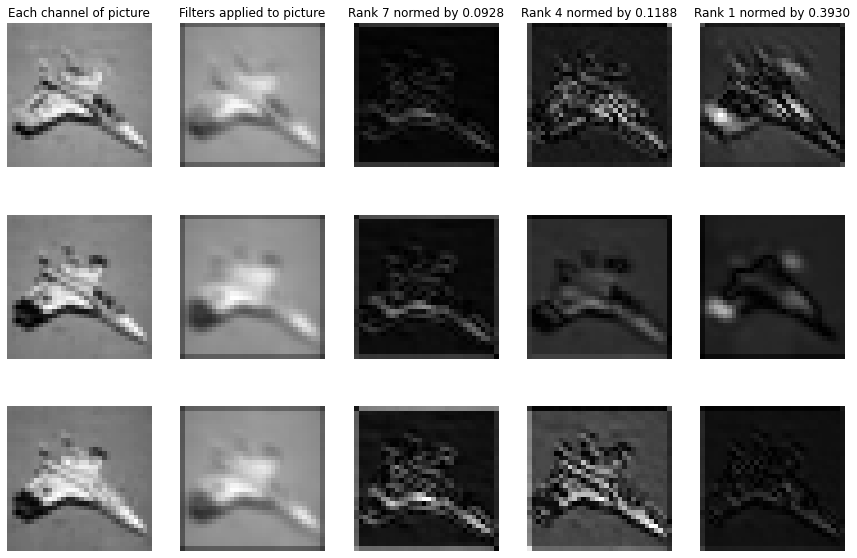

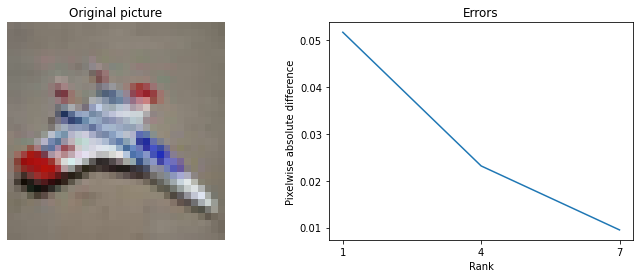

In [40]:
# making 4D decomposition depend on RANK

from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

img = X_train[30]

inputchannel = 3
outputchannel = 3
spatialx = 3
spatialy = 3
padding = 1
dim = 32

# Retrieving the picture
dog = torch.divide(torch.tensor(img).reshape(1,dim,dim,inputchannel).double(),255)
dog1 = dog[:,:,:,0]
dog2 = dog[:,:,:,1]
dog3 = dog[:,:,:,2]
dog_t = torch.cat((dog1.reshape(1,1,dim,dim),dog2.reshape(1,1,dim,dim),dog3.reshape(1,1,dim,dim)),1)

[X,Y,Z] = np.meshgrid([-1.,2,-1],[-1.,2,-1],[-1.,2,-1])
GRID1 = X+Y+Z
[X,Y,Z] = np.meshgrid([0,1,0.5],[0,1,0],[0.5,1,0])
GRID2 = X+Y+Z
[X,Y,Z] = np.meshgrid([1.,0,0.5],[0,1,0],[0.5,0,1])
GRID3 = X+Y+Z

# https://en.wikipedia.org/wiki/Kernel_(image_processing)
GRID1 = np.array([[[1, 0, 0],[0, 1, 0.],[0, 0, 1]],[[0, 1, 0],[ 0, 0,  1.],[1, 0, 0]],[[0,0,1],[ 1, 0, 0.],[0, 1, 0]]])
GRID2 = np.array([[[1/3,1/3,1/3.],[1/3,1/3,1/3.],[1/3,1/3,1/3.]],[[1/3,1/3,1/3.],[1/3,1/3,1/3.],[1/3,1/3,1/3.]],[[1/3,1/3,1/3.],[1/3,1/3,1/3.],[1/3,1/3,1/3.]]])
GRID3 = np.divide(np.random.rand(3,3,3),4.5)

GRID1[0] = np.divide(GRID1[0],2) # 3/2
GRID1[1] = np.divide(GRID1[1],3) # 1
GRID1[2] = np.divide(GRID1[2],6) # 1/2
GRID2[0] = np.divide(GRID2[0],6) # 3/2
GRID2[1] = np.divide(GRID2[1],3) # 1
GRID2[2] = np.divide(GRID2[2],2) # 1/2

conv1_filter = torch.tensor(GRID1.reshape(inputchannel,spatialx,spatialy,1))
conv2_filter = torch.tensor(GRID2.reshape(inputchannel,spatialx,spatialy,1))
conv3_filter = torch.tensor(GRID3.reshape(inputchannel,spatialx,spatialy,1))
FILTER = torch.cat((conv1_filter,conv2_filter,conv3_filter),3)

convFilter1 = F.conv2d(dog_t, conv1_filter.reshape(1,inputchannel,spatialx,spatialy), padding = padding)
convFilter2 = F.conv2d(dog_t, conv2_filter.reshape(1,inputchannel,spatialx,spatialy), padding = padding)
convFilter3 = F.conv2d(dog_t, conv3_filter.reshape(1,inputchannel,spatialx,spatialy), padding = padding)

RANKLIST = [7,4,1]

ERRORLIST = []
OUTPUT = []

for r,R in enumerate(RANKLIST):

    print("Calculating for rank: " + str(R))
    RANK = R

    RFD = tl.decomposition.parafac(tl.tensor(FILTER), rank = RANK)

    FilterList = []
    for i in range(4):
        FilterList.append(RFD[1][i])

    # Applying the filters to the layers
    Layer1List = []
    for i in range(RANK):
        Layer1List.append(F.conv2d(dog_t,torch.tensor(FilterList[0][:,i].reshape(1,inputchannel,1,1))))

    Layer2List = []
    for i in range(RANK):
        Layer2List.append(F.conv2d(Layer1List[i],torch.tensor(FilterList[1][:,i].reshape(1,1,spatialx,1)),padding = padding))

    Layer3List = []
    Layer3 = []
    for i in range(RANK):
        Layer3List.append(F.conv2d(Layer2List[i],torch.tensor(FilterList[2][:,i].reshape(1,1,1,spatialy))))
        if i == 0:
            Layer3 = Layer3List[i]
        else:
            Layer3 = torch.cat((Layer3,Layer3List[-1]),1)

    Layer4List = []
    for i in range(outputchannel):
        Layer4List.append(F.conv2d(Layer3,torch.tensor(FilterList[3][i].reshape(1,RANK,1,1))))

    OUTPUT.append(Layer4List)
    ERRORLIST.append((sum(abs(Layer4List[0].reshape(dim*dim)-convFilter1.reshape(dim*dim))) + \
                     sum(abs(Layer4List[1].reshape(dim*dim)-convFilter2.reshape(dim*dim))) + \
                     sum(abs(Layer4List[2].reshape(dim*dim)-convFilter3.reshape(dim*dim)))).numpy() / (dim*dim*inputchannel)) 
    

# show the original filters applied to the pictures and the decomposed filters applied.
fig, axs = plt.subplots(inputchannel, 2+len(RANKLIST),figsize=(15,10))

maxval = 0
minval = 0
y = torch.min(convFilter1.reshape(dim,dim))
if minval > y: minval = y
y = torch.min(convFilter2.reshape(dim,dim))
if minval > y: minval = y
y = torch.min(convFilter3.reshape(dim,dim))
if minval > y: minval = y_test

t = torch.max(convFilter1.reshape(dim,dim))
if maxval < t: maxval = t
t = torch.max(convFilter2.reshape(dim,dim))
if maxval < t: maxval = t
t = torch.max(convFilter3.reshape(dim,dim))
if maxval < t: maxval = t

print(minval,maxval)

axs[0,0].imshow(dog1.reshape(dim,dim), cmap='gray')
axs[1,0].imshow(dog2.reshape(dim,dim), cmap='gray')
axs[2,0].imshow(dog3.reshape(dim,dim), cmap='gray')

axs[0,1].imshow(torch.divide(convFilter1.reshape(dim,dim),maxval), cmap='gray', vmin = 0, vmax = 1)
axs[1,1].imshow(torch.divide(convFilter2.reshape(dim,dim),maxval), cmap='gray', vmin = 0, vmax = 1)
axs[2,1].imshow(torch.divide(convFilter3.reshape(dim,dim),maxval), cmap='gray', vmin = 0, vmax = 1)

# Showing the result
for r in range(len(RANKLIST)):
  maxval2 = 0
  t = torch.max(abs(OUTPUT[r][0]-convFilter1).reshape(dim,dim))
  if maxval2 < t: maxval2 = t
  t = torch.max(abs(OUTPUT[r][1]-convFilter2).reshape(dim,dim))
  if maxval2 < t: maxval2 = t
  t = torch.max(abs(OUTPUT[r][2]-convFilter3).reshape(dim,dim))
  if maxval2 < t: maxval2 = t

  minval2 = 0
  y = torch.min(convFilter1.reshape(dim,dim))
  if minval2 > y: minval2 = y
  y = torch.min(convFilter2.reshape(dim,dim))
  if minval2 > y: minval2 = y
  y = torch.min(convFilter3.reshape(dim,dim))
  if minval2 > y: minval2 = y

  plt1 = torch.divide(abs(OUTPUT[r][0]-convFilter1).reshape(dim,dim),maxval2)
  plt2 = torch.divide(abs(OUTPUT[r][1]-convFilter2).reshape(dim,dim),maxval2)
  plt3 = torch.divide(abs(OUTPUT[r][2]-convFilter3).reshape(dim,dim),maxval2)
  axs[0,r+2].imshow(plt1, cmap='gray', vmin = 0, vmax = 1)
  axs[1,r+2].imshow(plt2, cmap='gray', vmin = 0, vmax = 1)
  axs[2,r+2].imshow(plt3, cmap='gray', vmin = 0, vmax = 1)

  axs[0,r+2].set_title("Rank " + str(RANKLIST[r]) + " normed by " + str(maxval2.numpy())[0:6])

axs[0,0].set_title("Each channel of picture")
axs[0,1].set_title("Filters applied to picture")

for i in range(3):
    for j in range(2+len(RANKLIST)):
      axs[i,j].axis('off')

plt.show()

fig2, axs2 = plt.subplots(1, 2,figsize=(12,4))
axs2[0].imshow(img, cmap='gray')
axs2[0].set_title("Original picture")
axs2[0].axis('off')
axs2[1].plot(RANKLIST,ERRORLIST)
axs2[1].set_title("Errors")
plt.sca(axs2[1])
plt.xticks([1,4,7], [1,4,7])
plt.xlabel('Rank')
plt.ylabel('Pixelwise absolute difference')

plt.show()



In [ ]:
RFD[1][3]

In [ ]:
# making 4D decomposition depend on RANK

inputchannel = 3
outputchannel = 3
spatialx = 5
spatialy = 5
padding = 2
dimx = 768
dimy = 1024

# Retrieving the picture
face = scipy.misc.face()
racoon = face
racoon = torch.tensor(racoon).double()
racoon1 = racoon[:,:,0]
racoon2 = racoon[:,:,1]
racoon3 = racoon[:,:,2]
racoon_t = torch.cat((racoon1.reshape(1,1,dimx,dimy),racoon2.reshape(1,1,dimx,dimy),racoon3.reshape(1,1,dimx,dimy)),1)

[X,Y,Z] = np.meshgrid(np.multiply([0,0.2,0.5,0.2,0],10),[1,0,-1.5],[0,0.3,0.5,0.2,0])
GRID1 = X+Y+Z
[X,Y,Z] = np.meshgrid([0,0.26,0.5,0.21,0],np.multiply([0.3,0.1,-0.5],23),[0,0.2,0.5,0.25,0])
GRID2 = X+Y+Z
[X,Y,Z] = np.meshgrid([0,0.2,0.5,1,1.1],[0.3,0.1,0.5],np.multiply([0,0.2,0.5,0.2,1],5))
GRID3 = X+Y+Z

conv1_filter = torch.tensor(GRID1.reshape(inputchannel,spatialx,spatialy,1))
conv2_filter = torch.tensor(GRID2.reshape(inputchannel,spatialx,spatialy,1))
conv3_filter = torch.tensor(GRID3.reshape(inputchannel,spatialx,spatialy,1))
FILTER = torch.cat((conv1_filter,conv2_filter,conv3_filter),3)

convFilter1 = F.conv2d(racoon_t, conv1_filter.reshape(1,inputchannel,spatialx,spatialy), padding = padding)
convFilter2 = F.conv2d(racoon_t, conv2_filter.reshape(1,inputchannel,spatialx,spatialy), padding = padding)
convFilter3 = F.conv2d(racoon_t, conv3_filter.reshape(1,inputchannel,spatialx,spatialy), padding = padding)

RANKLIST = [4,10]
OUTPUT = []

fig, axs = plt.subplots(inputchannel*2, 2+len(RANKLIST), figsize=(15,10))
axs[0,0].imshow(racoon1.reshape(dimx,dimy))
axs[1,0].axis('off')
axs[2,0].imshow(racoon2.reshape(dimx,dimy))
axs[3,0].axis('off')
axs[4,0].imshow(racoon3.reshape(dimx,dimy))
axs[5,0].axis('off')
#axs[3,0].imshow(racoon)
#axs[4,0].imshow(racoon-racoon)
axs[0,1].imshow(convFilter1.reshape(dimx,dimy))
axs[1,1].axis('off')
axs[2,1].imshow(convFilter2.reshape(dimx,dimy))
axs[3,1].axis('off')
axs[4,1].imshow(convFilter3.reshape(dimx,dimy))
axs[5,1].axis('off')
#convfig = torch.cat((convFilter1.reshape(dimx,dimy,1),convFilter2.reshape(dimx,dimy,1),convFilter3.reshape(dimx,dimy,1)),2)
#convfig = convfig-torch.min(convfig)
#axs[3,1].imshow(convfig)
#axs[4,1].imshow(racoon)

ERRORLIST = []
OUTPUT = []

for r,R in enumerate(RANKLIST):
    print("Calculating for rank: " + str(R))
    RANK = R

    RFD = tl.decomposition.parafac(tl.tensor(FILTER), rank = RANK)

    FilterList = []
    for i in range(4):
        FilterList.append(RFD[1][i])

    # Applying the filters to the layers
    Layer1List = []
    for i in range(RANK):
        Layer1List.append(F.conv2d(racoon_t,torch.tensor(FilterList[0][:,i].reshape(1,inputchannel,1,1))))

    Layer2List = []
    for i in range(RANK):
        Layer2List.append(F.conv2d(Layer1List[i],torch.tensor(FilterList[1][:,i].reshape(1,1,spatialx,1)),padding = padding))

    Layer3List = []
    Layer3 = []
    for i in range(RANK):
        Layer3List.append(F.conv2d(Layer2List[i],torch.tensor(FilterList[2][:,i].reshape(1,1,1,spatialy))))
        if i == 0:
            Layer3 = Layer3List[i]
        else:
            Layer3 = torch.cat((Layer3,Layer3List[-1]),1)

    Layer4List = []
    for i in range(outputchannel):
        Layer4List.append(F.conv2d(Layer3,torch.tensor(FilterList[3][i].reshape(1,RANK,1,1))))

    OUTPUT.append(Layer4List)

    # Calculating the difference
    ERRORLIST.append(sum(abs(Layer4List[0].reshape(dimx*dimy)-convFilter1.reshape(dimx*dimy))) + \
                     sum(abs(Layer4List[1].reshape(dimx*dimy)-convFilter2.reshape(dimx*dimy))) + \
                     sum(abs(Layer4List[2].reshape(dimx*dimy)-convFilter3.reshape(dimx*dimy))).numpy())


# Showing the result

# Showing the result
for r in range(len(RANKLIST)):
  axs[0,r+2].imshow(OUTPUT[r][0].reshape(dimx,dimy))
  axs[1,r+2].imshow(abs(OUTPUT[r][0]-convFilter1).reshape(dimx,dimy))
  axs[2,r+2].imshow(OUTPUT[r][1].reshape(dimx,dimy))
  axs[3,r+2].imshow(abs(OUTPUT[r][1]-convFilter2).reshape(dimx,dimy))
  axs[4,r+2].imshow(OUTPUT[r][2].reshape(dimx,dimy))
  axs[5,r+2].imshow(abs(OUTPUT[r][2]-convFilter3).reshape(dimx,dimy))

for i in range(3):
    for j in range(2+len(RANKLIST)):
        axs[i,j].axis('off')
plt.show()

plt.plot(RANKLIST,ERRORLIST)
plt.xticks(RANKLIST, RANKLIST)
plt.xlabel("Rank")
plt.ylabel("Error")
plt.title("Difference between filter and decomposition")
plt.show()


In [ ]:
def apply_decomp(inputchannel, outputchannel, spatial, padding, dimx, dimy, FD, num_batches, RANK):
  FilterList = []
  for i in range(4):
      FilterList.append(FD[1][i])

  # Applying the filters to the layers
  Layer1List = []
  for i in range(RANK):
      Layer1List.append(F.conv2d(num_batches,torch.tensor(FilterList[0][:,i].reshape(1,inputchannel,1,1))))

  Layer2List = []
  for i in range(RANK):
      Layer2List.append(F.conv2d(Layer1List[i],torch.tensor(FilterList[1][:,i].reshape(1,1,spatial,1)),padding = padding))

  Layer3List = []
  Layer3 = []
  for i in range(RANK):
      Layer3List.append(F.conv2d(Layer2List[i],torch.tensor(FilterList[2][:,i].reshape(1,1,1,spatial))))
      if i == 0:
        Layer3 = Layer3List[i]
      else:
        Layer3 = torch.cat((Layer3,Layer3List[-1]),1)

  Layer4List = []
  for i in range(outputchannel):
      Layer4List.append(F.conv2d(Layer3,torch.tensor(FilterList[3][i].reshape(1,RANK,1,1))))
  
  return (Layer4List)

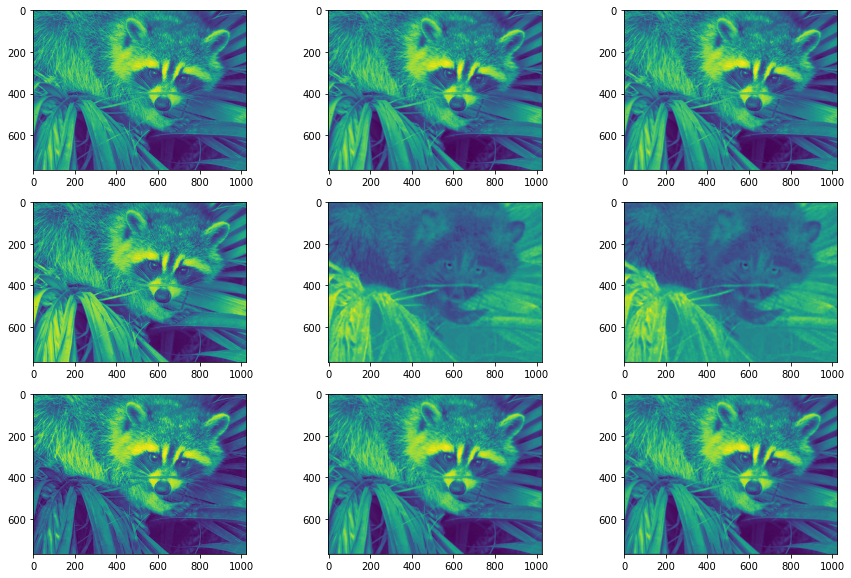

In [ ]:
racoon = scipy.misc.face()
racoon = torch.tensor(racoon).double().permute(2,0,1).reshape(1,3,dimx,dimy)

inputchannel = 3
outputchannel = 3
spatial = 5
padding = 2
dimx = 768
dimy = 1024

fig, axs = plt.subplots(inputchannel, 2+1, figsize=(15,10))
axs[0,0].imshow(racoon1.reshape(dimx,dimy))
axs[1,0].imshow(racoon2.reshape(dimx,dimy))
axs[2,0].imshow(racoon3.reshape(dimx,dimy))
axs[0,1].imshow(convFilter1.reshape(dimx,dimy))
axs[1,1].imshow(convFilter2.reshape(dimx,dimy))
axs[2,1].imshow(convFilter3.reshape(dimx,dimy))

FD = tl.decomposition.parafac(tl.tensor(FILTER), rank = 10)

L4 = apply_decomp(inputchannel, outputchannel, spatial, padding, dimx, dimy, FD, racoon, RANK)

axs[0,2].imshow(L4[0].reshape(dimx,dimy))
axs[1,2].imshow(L4[1].reshape(dimx,dimy))
axs[2,2].imshow(L4[2].reshape(dimx,dimy))

plt.show()
